In [12]:
import os
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

In [2]:
try:
    _ = first_run
except NameError:
    first_run = True
    os.chdir(os.getcwd().rsplit("/", 1)[0])

# Load Data

In [3]:
df = pd.read_csv("../data/train/X_train.csv", index_col=0).join(pd.read_csv("../data/train/y_train.csv", index_col=0))

# Generate basic profile

In [4]:
profile = ProfileReport(
    df,
    title="Basic Profile Report - Klarna Dataset",
    explorative=True,
    pool_size=8,
    sort="ascending",
    vars={
        "cat": {
            "words": True,
            "cardinality_threshold": 10
        }
    },
    html={
        "style":{
            "full_width": True
        }
    }

)

In [63]:
profile.to_file("1_sanity/basic_profile.html")

## 1. Making sense of variables in the dataset

Let's try to give a qualitative definition of each variable in the dataset

**Personal variables**
- age
- name_in_email: how much of the account owner's name can be found in their email

**Status variables**<br/>
They seem to be ordinal (hence the max in some of them), with 1.0 being the normal status and 4.0 being the worst. From the principle "customer obssession", it seems reasonable to assume missing values should default to 1.0. In other words, the account is considered normal until proven otherwise.
- account_status: the current status of the account
- account_worst_status_M_Nm: the worst status (max) in the M to N period in months
- status_max_archived_M_N_months: the max (worst) status for archieved invoices
- status_Nth_archived_M_Nm: status of the last Nth archived invoice between M and N months ago
    - 0 through 5, with 1 being the most commom status... perhaps:
        - 0 means paid on the spot
        - 1 means paid fully in short term installments
        - 2 means paid fully in longer term installments
        - 3 means paid fully in installments with fee due to delays in payment
        - 4 means not paid in full (is not present in the train dataset)
        - 5 means not paid at all
    
**Account variables**
- account_amount_added_12_24m: money deposited into the app for cardless purchases
- account_incoming_debt_vs_paid_0_24m: ratio "new_debt / old_paid_debt"
- account_days_in_dc_M_Nm: number of days an account was put into status "dc" between M and N months ago (?)
- account_days_in_rem_M_Nm: number of days an account was put into status "rem" between M and N months ago (?)
- account_days_in_term_M_Nm: number of days an account was put into status "term" between M and N months ago (terminated ?)

**Payment variables**
- avg_payment_span_M_Nm: the average number of days to liquidate debt looking back between M and N months ago
- has_paid: whether the account has paid the latest installment
- max_paid_inv_M_Nm: the amount of the largest purchase the account has made between M and N months ago
- sum_capital_paid_account_M_Nm: the total amount of money paid with account funds between M and N months ago
- sum_paid_inv_0_12m: the total amount of money paid with installments (card) between M and N months ago

**Count variables**
- num_active_inv: number of active invoices
- num_unpaid_bills: number of installments still unpaid
- num_active_div_by_paid_inv_M_Nm: ratio "number_active_invoices / number_paid_invoices" between M and N months ago
    - null when number_paid_invoices is zero
    - can be imputed, what's the best way?
- num_arch_dc_M_Nm: number of archieved invoices with status "dc" between M and N months ago (?)
- num_arch_ok_M_Nm: number of archieved invoices with status "ok" between M and N months ago
- num_arch_rem_M_Nm: number of archieved invoices with status "rem" between M and N months ago (?)
- num_arch_written_off_M_Nm: number of archieved invoices that were unpaid between M and N months ago

**Order variables**
- merchant_category: category of the merchant receiving the order
- merchant_group: group of the merchant receiving the order

---
## 2. Making sense of macro behaviours in the dataset

### Not-so-old accounts
The account did not exist before 12 months:
- account_days_in_dc_12_24m (11.9% missing, 87.9% zero)
- account_days_in_rem_12_24m (11.9% missing, 78.5% zero)
- account_days_in_term_12_24m (11.9% missing, 86.9% zero)
- num_arch_dc_12_24m - not treated as missing, zero instead (96.0%)
- num_arch_ok_12_24m - not treated as missing, zero instead (37.8%)
- num_arch_written_off_12_24m - 18% missing and most observations are 0 (+99.9%)
- sum_capital_paid_account_12_24m - not treated as missing, zero instead (74.7%)

We can already get an idea that looking back further than 12 months is likely to introduce too much noise.

### Missing account status
Many accounts (>54.3%) do not have information about their statuses. The first scenario that comes to mind is that accounts that have not made a previous purchase cannot be assigned a status. **How can we check that?**
- account_status (54.3%)
- account_worst_status_0_3m (54.3%)
- account_worst_status_12_24m (66.7%)
- account_worst_status_3_6m (57.7%)
- account_worst_status_6_12m (60.3%)


#### Before going any further, let's try to verify whether these seemly inactive accounts can be removed from the dataset.
(answer - they should not be removed)

<AxesSubplot:ylabel='Frequency'>

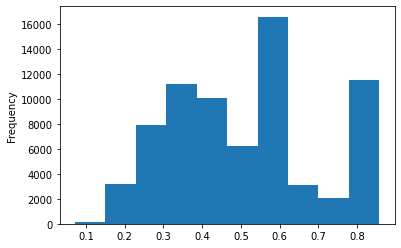

In [79]:
feature_count = df.drop(["uuid"], axis=1).shape[1]

account_irrelevant_values = (
    df.drop(["uuid"], axis=1)
    .replace(0, np.nan)
    .apply(lambda account: account.isna().sum() / feature_count, axis=1)
)

account_irrelevant_values.plot.hist()

### New accounts?

We can see that there is a high concentration of accounts that have +80% of missing or zero value. We must find out what makes up the remaining <20% of apparently good information. If the missing data is related to snapshot variables, it becomes safer to assume that these are new accounts.
> Note that zero values are not always bad, but having all (or most) variables as zero suggests that the register is irrelevant

In [120]:
# drop columns that are all NaN or Zero

(
    account_irrelevant_values.to_frame(name="missing_percent")
    .loc[(account_irrelevant_values >= .80) & (account_irrelevant_values < .85)]
    .join(df)
    .replace(0, np.nan)
    .dropna(how="all", axis=1)
    .info()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 4633 to 4754
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   missing_percent            271 non-null    float64
 1   uuid                       271 non-null    object 
 2   account_status             9 non-null      float64
 3   account_worst_status_0_3m  9 non-null      float64
 4   age                        271 non-null    int64  
 5   merchant_category          271 non-null    object 
 6   merchant_group             271 non-null    object 
 7   has_paid                   271 non-null    bool   
 8   max_paid_inv_0_24m         48 non-null     float64
 9   name_in_email              271 non-null    object 
 10  num_unpaid_bills           10 non-null     float64
 11  recovery_debt              1 non-null      float64
 12  time_hours                 271 non-null    float64
 13  default                    206 non-null    flo

Taking a look at these columns, we can see that "age", merchant info, "time_hours" and "name_in_email" compose most of these accounts relevant information. We do not consider "has_paid" to be relevant in this set of accounts due to it likely being set to "False" by default.

This observation makes it reasonable to assume these are mostly new accounts since they have close to none information about snapshot. Thus, imputing all values to zero and grouping them with the rest sounds rather irresponsible and is bound to deter any significant performance. Hence, we will need to break our solution into two separate processes, one for old accounts (warm-start) and another for new accounts (cold-start). Note that the latter makes up ~14% of our dataset.
> Note that 20% of defaults are in the \[.8, .85) group and none are in the (.85, 1.0\]

### What about the second peak of accounts with 55-60% of missing or zero values?


In [82]:
# drop columns that are all NaN or Zero

(
    account_irrelevant_values.to_frame(name="missing_percent")
    .loc[(account_irrelevant_values >= .55) & (account_irrelevant_values < .6)]
    .join(df)
    .replace(0, np.nan)
    .dropna(how="all", axis=1)
    .info()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7186 entries, 74231 to 81884
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   missing_percent                      7186 non-null   float64
 1   uuid                                 7186 non-null   object 
 2   account_amount_added_12_24m          314 non-null    float64
 3   account_days_in_dc_12_24m            3 non-null      float64
 4   account_days_in_rem_12_24m           143 non-null    float64
 5   account_days_in_term_12_24m          18 non-null     float64
 6   account_incoming_debt_vs_paid_0_24m  302 non-null    float64
 7   account_status                       678 non-null    float64
 8   account_worst_status_0_3m            678 non-null    float64
 9   account_worst_status_12_24m          387 non-null    float64
 10  account_worst_status_3_6m            562 non-null    float64
 11  account_worst_status_6_12

Although some columns have a lot of missing/zero values, they do have some relevant information which, in turn, possibly makes zero values relevant.

The following columns have mostly missing values:
- account_incoming_debt_vs_paid_0_24m
- account_status
- account_worst_status_0_3m
- account_worst_status_12_24m
- account_worst_status_3_6m
- account_worst_status_6_12m
- recovery_debt
- worst_status_active_inv

If we see that a sample of these variables explain well enough the default label, it becomes reasonable to think about imputing some of them. We will explore this in the next section.

